In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
# First, read the CSV file.
plastic_correlation = Table.read_table("Plastic_Summary_Table_Correlation_Fashion.csv")
plastic_correlation.show()

Product_Type,Correlation_Coefficient,Plastic_Or_Not
Polyester,0.1726,Plastic
Nylon,0.0345,Plastic
Recycled_Poly,-0.0083,Plastic
Cotton,-0.0114,Not_Plastic
Synthetic_Blend,0.0847,Plastic
Organic_Cotton,0.0114,Not_Plastic
Microfiber,0.0784,Plastic
Linen,0.027,Not_Plastic
Tencel,0.0204,Not_Plastic
Viscose,0.0883,Not_Plastic


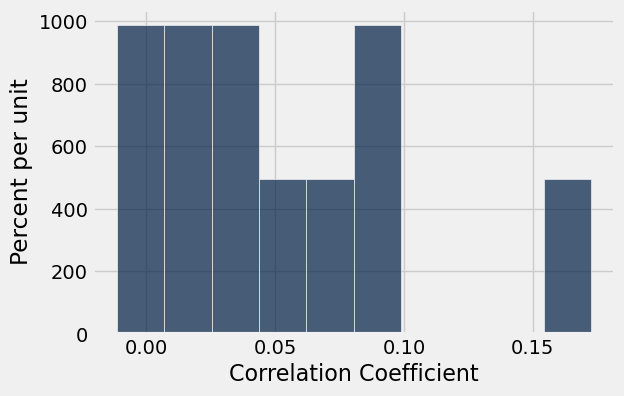

In [3]:
plastic_correlation.relabeled("Correlation_Coefficient", 
                              "Correlation Coefficient").hist("Correlation Coefficient")

In [4]:
# Second, I'm grouping by column "DEI".
plastic_correlation.group("Plastic_Or_Not")

Plastic_Or_Not,count
Not_Plastic,6
Plastic,5


In [5]:
# Third, I'm solving the average score based on each group.
plastic_correlation_group = plastic_correlation.group("Plastic_Or_Not", np.median).select("Plastic_Or_Not", "Correlation_Coefficient median")
plastic_correlation_group

Plastic_Or_Not,Correlation_Coefficient median
Not_Plastic,0.0237
Plastic,0.0784


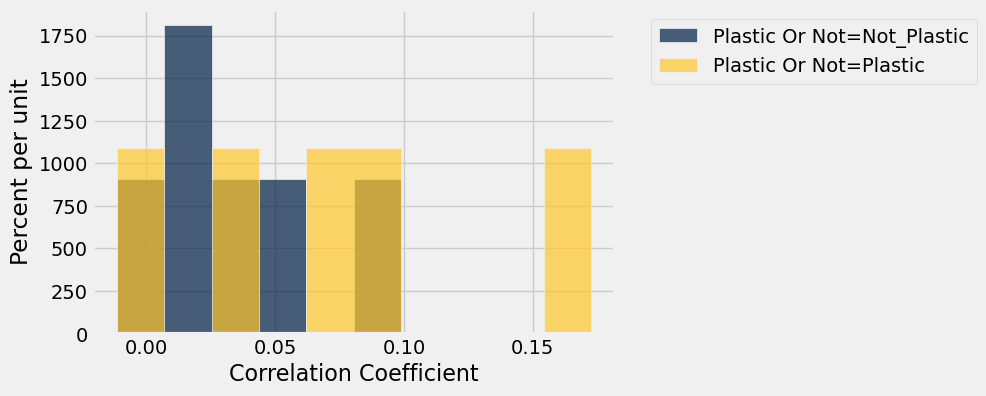

In [6]:
# Let's visualize how each group's histogram looks like.
plastic_correlation.relabeled("Correlation_Coefficient", 
                              "Correlation Coefficient").relabeled("Plastic_Or_Not", 
                                                                   "Plastic Or Not").hist("Correlation Coefficient", 
                                                                                          group = "Plastic Or Not")

In [7]:
# Fourth, let's see the observed difference between "DEI=FALSE" and "DEI=TRUE". 
# I'm giving up the "UNKNOWN" because there is only 1 "DEI=UNKNOWN" data, and it's an obvious outlier. 

means = plastic_correlation_group.column(1)
means

array([ 0.0237,  0.0784])

In [8]:
# Now, compute the observed difference between "TRUE" and "FALSE".
observed_difference = means.item(1) - means.item(0)
observed_difference

0.0547

In [9]:
# For faster process purposes, create a funciton to compute the observed statistics.
def difference_of_means(table, group_label):
    """Takes: name of table,
    column label that indicates the group to which the row belongs
    Returns: Difference of mean 2023 final score of the two groups between DEI-TRUE and DEI-FALSE
    We're ignoring the UNKNOWN-DEI at this moment."""
    reduced = table.select("Correlation_Coefficient", group_label)
    means_table = reduced.group(group_label, np.average)
    means = means_table.column(1)
    return means.item(1) - means.item(0)

In [10]:
# Verify the function to see if it's equal to our previous observed difference! YES, they are equal!
difference_of_means(plastic_correlation, "Plastic_Or_Not")

0.04141333333333333

In [11]:
# Fifth, let process the two group testing by using Permutation Test.
# Define another funciton first.

def one_simulated_difference_of_means():
    """Returns: Difference between mean 2023 final score of DEI=FALSE and DEI=TRUE fter shuffling labels"""
    
    # array of shuffled labels
    shuffled_labels = plastic_correlation.sample(with_replacement=False).column("Plastic_Or_Not")
    
    # table of 2023 final scores and shuffled labels
    shuffled_table = plastic_correlation.select("Correlation_Coefficient").with_column("Shuffled Label",
                                                                                       shuffled_labels)
    
    return difference_of_means(shuffled_table, 'Shuffled Label')

# Compute one simulated statistics.
one_simulated_difference_of_means()

0.02040333333333333

In [12]:
# Set up for-loop.
differences = make_array()

repetitions = 10000
for i in np.arange(repetitions):
    new_difference = one_simulated_difference_of_means()
    differences = np.append(differences, new_difference)                               

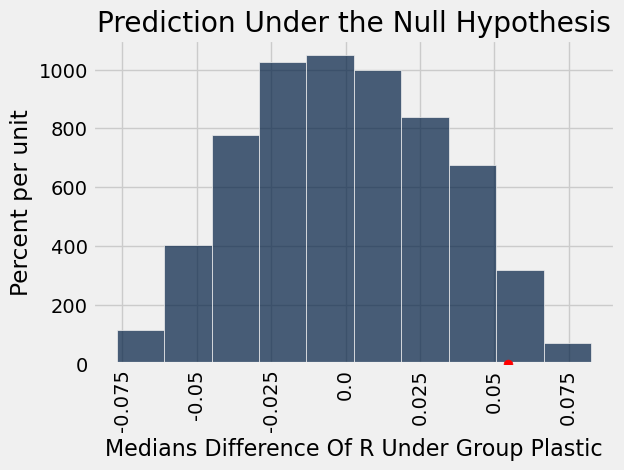

In [13]:
# Make a plot for visulization.
Table().with_column("Medians Difference Of R Under Group Plastic", differences).hist()
plots.scatter(observed_difference, 0, color='red', s=40, zorder=3)
plots.title('Prediction Under the Null Hypothesis');

In [14]:
np.count_nonzero(differences >= observed_difference)

459

In [15]:
# Last, find out the empirical p-value.

empirical_p = np.count_nonzero(differences >= observed_difference) / repetitions
empirical_p

0.0459

In [16]:
np.percentile(differences, 2.5)

-0.058100000000000006

In [17]:
np.percentile(differences, 97.5)

0.061286666666666656

In [18]:
np.percentile(differences, 95)

0.05325666666666666